# `HFSAnomalyModel` Tutorial

Trey V. Wenger (c) December 2024

`HFSAnomalyModel` is like `HFSLTEModel`, but allows for non-LTE variations in hyperfine component optical depths, often called "hyperfine anomalies." This notebook demonstrates this model and is otherwise nearly identical to the `HFSLTEModel` notebook.

In [1]:
# General imports
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+2.g3f0e12d.dirty


## `get_molecule_data`

In [2]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
print(mol_data_12CN.keys())
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Upper state degrees of freedom:", mol_data_12CN['degu'])
print("Upper state energy level (erg)", mol_data_12CN['Eu'])
print("Relative intensities", mol_data_12CN['relative_int'])
print("Partition function terms:", mol_data_12CN["log10_Q_terms"])

# molecular weight (number of protons)
weight_12CN = 12.0 + 14.0

dict_keys(['freq', 'Aul', 'degu', 'Eu', 'relative_int', 'log10_Q_terms'])
transition frequency (MHz): [113123.3687 113144.19   113170.535  113191.325  113488.142  113490.985
 113499.643  113508.934  113520.4215]
Einstein A coefficient (s-1): [1.26969616e-06 1.03939111e-05 5.07869910e-06 6.59525390e-06
 6.64784064e-06 1.17706070e-05 1.04919208e-05 5.12459350e-06
 1.28243028e-06]
Upper state degrees of freedom: [2 2 4 4 4 6 2 4 2]
Upper state energy level (erg) [7.49702428e-16 7.49701340e-16 7.50014955e-16 7.50013660e-16
 7.52119441e-16 7.51999228e-16 7.52195648e-16 7.52118159e-16
 7.52194276e-16]
Relative intensities [0.01204699 0.09860036 0.09633376 0.1250773  0.12574146 0.33394774
 0.09921527 0.09691221 0.01212491]
Partition function terms: [0.40307694 0.97433601]


## Simulating Data

1000


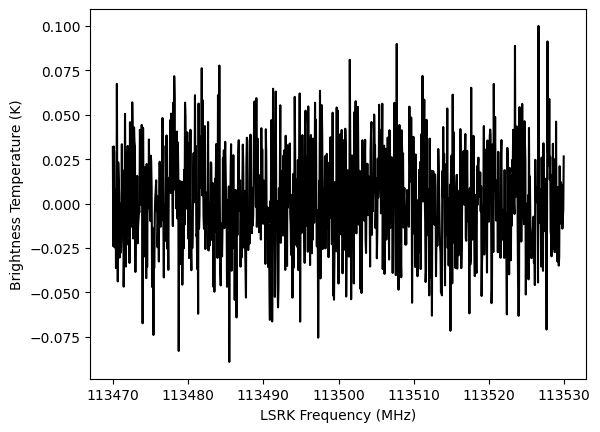

In [3]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis = np.arange(113470.0, 113530.0, 0.06) # MHz
# freq_axis = np.arange(113470.0, 113530.0, 0.2) # MHz
print(len(freq_axis))

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

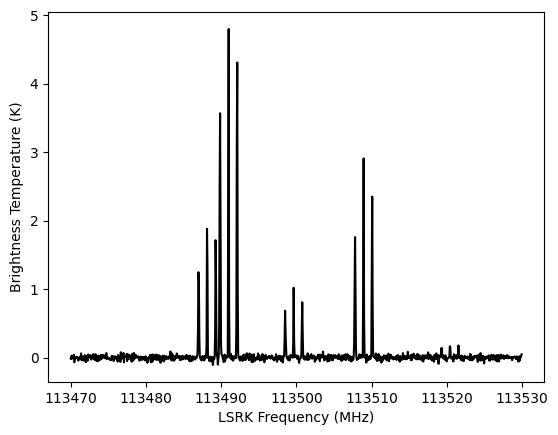

In [4]:
from bayes_cn_hfs import HFSAnomalyModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = HFSAnomalyModel(
    dummy_data,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total = 1.0, # width of total optical depth prior
    prior_log10_Tkin = [1.5, 0.2], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = None, # do not include non-thermal broadening
    prior_log10_anomaly = 0.1, # width of hyperfine anomaly prior (dex)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # default baseline priors
    fix_tau_total = None, # do not assume tau_total
    fix_log10_Tkin = None, # do not assume Tkin
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

log10_anomaly = np.zeros((len(model.mol_data['freq']), n_clouds))
for i, freq in enumerate(model.mol_data['freq']):
    if freq == 113499.643:
        log10_anomaly[i] = -0.2
    elif freq == 113508.934:
        log10_anomaly[i] = 0.2

sim_brightness = model.model.observation.eval({
    "tau_total": [1.0, 2.0, 0.5],
    "log10_Tkin": [1.5, 1.25, 1.75],
    "velocity": [-3.0, 0.0, 3.0],
    "fwhm_L": 0.0,
    "baseline_observation_norm": [0.0],
    "log10_anomaly": log10_anomaly,
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [5]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model Definition

In [6]:
# Initialize and define the model
model = HFSAnomalyModel(
    data,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total = 1.0, # width of total optical depth prior
    prior_log10_Tkin = [1.5, 0.2], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = None, # do not include non-thermal broadening
    prior_log10_anomaly = 0.1, # width of hyperfine anomaly prior (dex)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # default baseline priors
    fix_tau_total = None, # do not assume tau_total
    fix_log10_Tkin = None, # do not assume Tkin
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

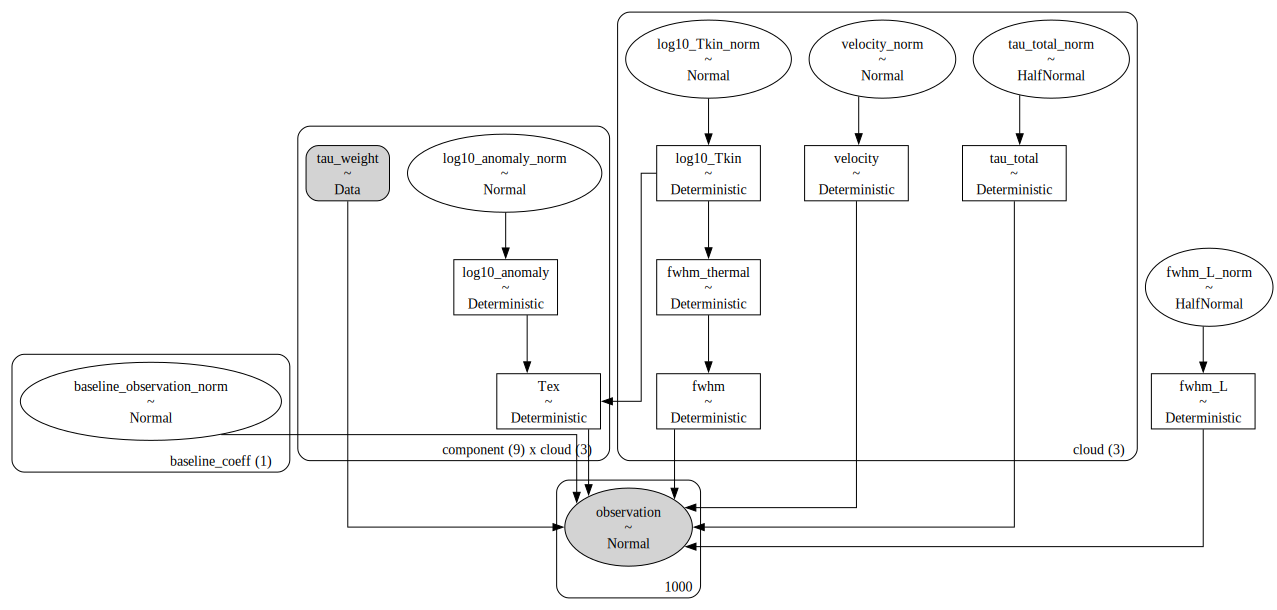

In [7]:
# Plot model graph
model.graph().render('hfs_anomaly_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

baseline_observation_norm ~ Normal(0, 1)
           tau_total_norm ~ HalfNormal(0, 1)
          log10_Tkin_norm ~ Normal(0, 1)
            velocity_norm ~ Normal(0, 1)
              fwhm_L_norm ~ HalfNormal(0, 1)
       log10_anomaly_norm ~ Normal(0, 1)
                tau_total ~ Deterministic(f(tau_total_norm))
               log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
                 velocity ~ Deterministic(f(velocity_norm))
             fwhm_thermal ~ Deterministic(f(log10_Tkin_norm))
                     fwhm ~ Deterministic(f(log10_Tkin_norm))
                   fwhm_L ~ Deterministic(f(fwhm_L_norm))
            log10_anomaly ~ Deterministic(f(log10_anomaly_norm))
                      Tex ~ Deterministic(f(log10_anomaly_norm, log10_Tkin_norm))
              observation ~ Normal(f(baseline_observation_norm, tau_total_norm, log10_anomaly_norm, log10_Tkin_norm, fwhm_L_norm, velocity_norm), <constant>)


Sampling: [baseline_observation_norm, fwhm_L_norm, log10_Tkin_norm, log10_anomaly_norm, observation, tau_total_norm, velocity_norm]


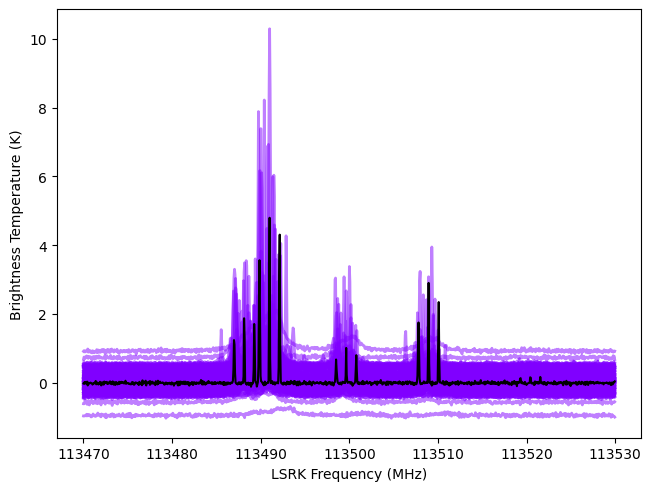

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 6200
Interrupted at 6,199 [6%]: Average Loss = 32,936


Output()

Runtime: 0.85 minutes


In [11]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_observation_norm[0],-0.156,0.003,-0.162,-0.150,0.000,0.000,1044.0,934.0,NaN
log10_Tkin_norm[0],1.252,0.014,1.223,1.277,0.000,0.000,951.0,982.0,NaN
log10_Tkin_norm[1],-1.249,0.010,-1.269,-1.232,0.000,0.000,850.0,970.0,NaN
log10_Tkin_norm[2],0.033,0.011,0.010,0.053,0.000,0.000,1129.0,1023.0,NaN
velocity_norm[0],0.998,0.001,0.997,1.000,0.000,0.000,939.0,934.0,NaN
velocity_norm[1],-0.000,0.001,-0.002,0.001,0.000,0.000,921.0,965.0,NaN
velocity_norm[2],-0.997,0.001,-0.998,-0.996,0.000,0.000,1037.0,985.0,NaN
"log10_anomaly_norm[113123.3687, 0]",-0.011,1.190,-2.157,2.217,0.039,0.027,943.0,874.0,NaN
"log10_anomaly_norm[113123.3687, 1]",0.063,1.102,-2.069,2.008,0.035,0.025,959.0,937.0,NaN
"log10_anomaly_norm[113123.3687, 2]",-0.004,1.139,-1.964,2.320,0.037,0.026,950.0,988.0,NaN


Sampling: [observation]


Output()

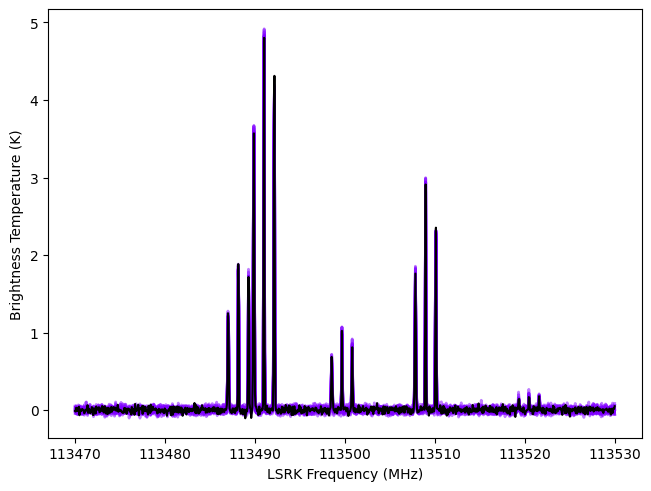

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6200
Interrupted at 6,199 [6%]: Average Loss = 32,936
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, tau_total_norm, log10_Tkin_norm, velocity_norm, fwhm_L_norm, log10_anomaly_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1492 seconds.


Adding log-likelihood to trace


Output()

Runtime: 26.32 minutes


In [14]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [15]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_observation_norm[0],-0.159,0.003,-0.164,-0.153,0.000,0.000,18004.0,5559.0,1.00
log10_Tkin_norm[0],1.257,0.040,1.181,1.331,0.000,0.000,16372.0,5486.0,1.00
log10_Tkin_norm[1],-1.309,0.066,-1.432,-1.185,0.001,0.001,6094.0,4826.0,1.00
log10_Tkin_norm[2],0.035,0.044,-0.045,0.119,0.000,0.000,11124.0,6070.0,1.00
velocity_norm[0],1.000,0.000,0.999,1.000,0.000,0.000,18560.0,5642.0,1.00
velocity_norm[1],0.000,0.000,-0.000,0.001,0.000,0.000,10195.0,6163.0,1.00
velocity_norm[2],-1.000,0.000,-1.001,-1.000,0.000,0.000,16937.0,5398.0,1.00
"log10_anomaly_norm[113123.3687, 0]",0.002,0.988,-1.880,1.799,0.008,0.013,15214.0,5881.0,1.00
"log10_anomaly_norm[113123.3687, 1]",-0.005,1.004,-1.814,1.919,0.008,0.013,17073.0,5819.0,1.00
"log10_anomaly_norm[113123.3687, 2]",-0.005,1.003,-1.842,1.944,0.008,0.013,16727.0,5823.0,1.00


Sampling: [observation]


Output()

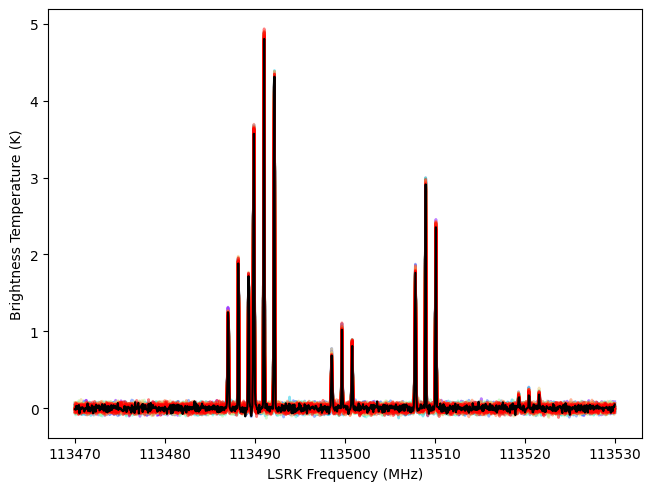

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

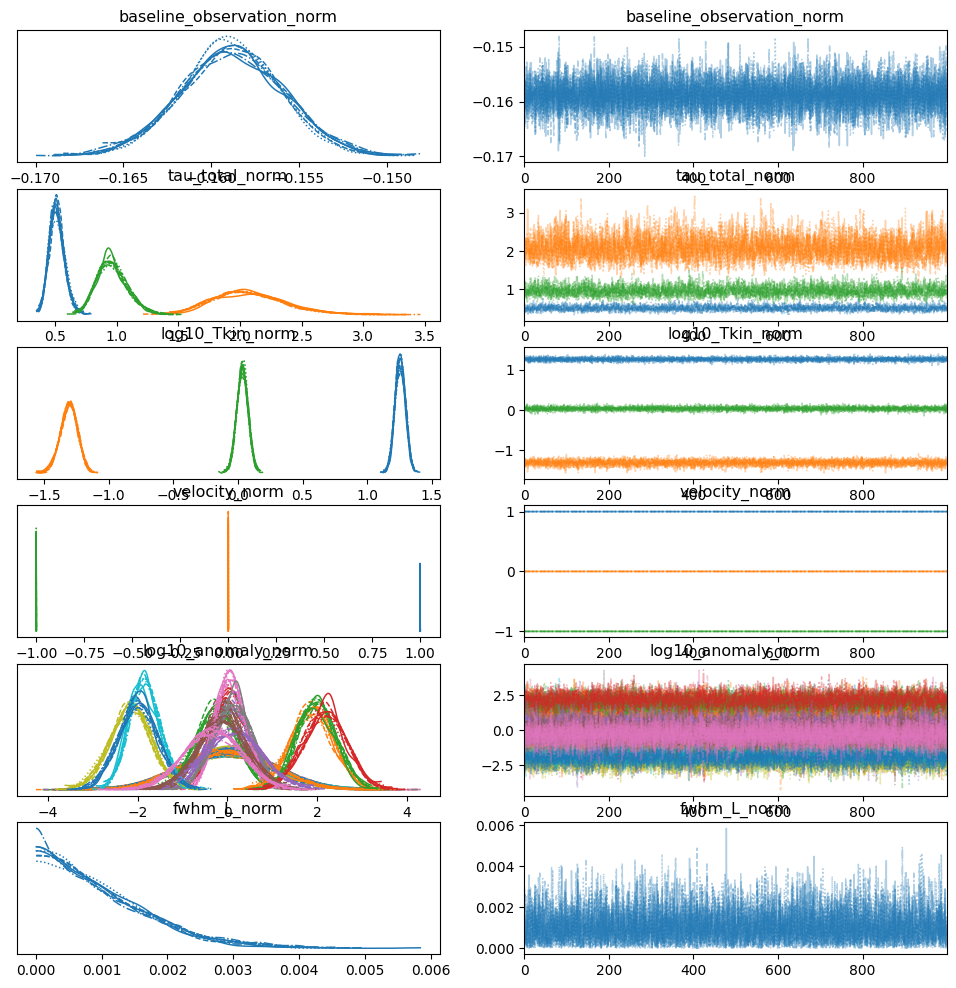

In [17]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.baseline_freeRVs + model.cloud_freeRVs + model.hyper_freeRVs)

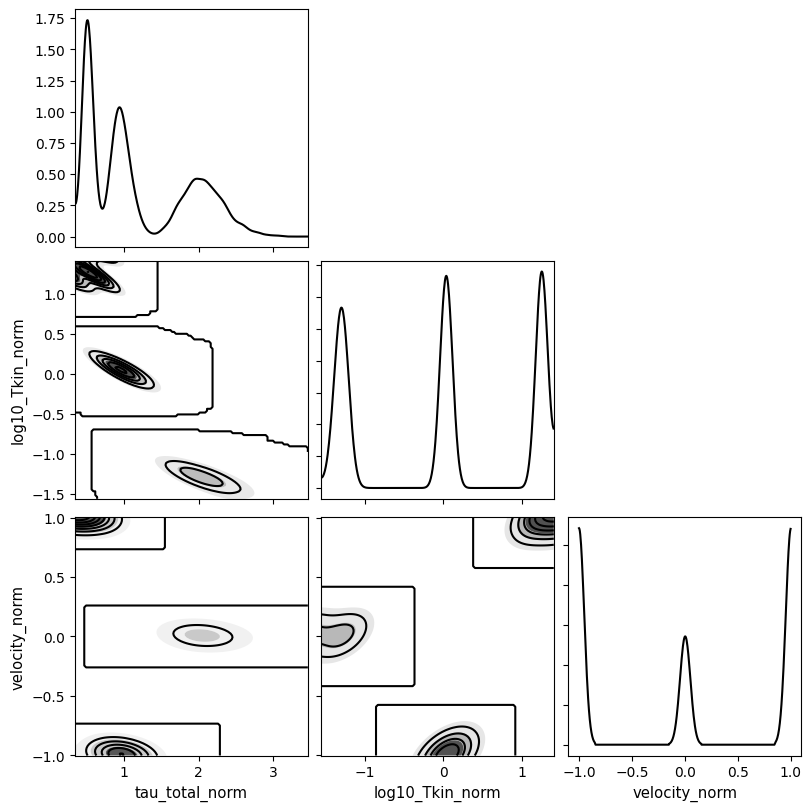

In [18]:
from bayes_spec.plots import plot_pair

var_names = [param for param in model.cloud_freeRVs if "anomaly" not in param]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

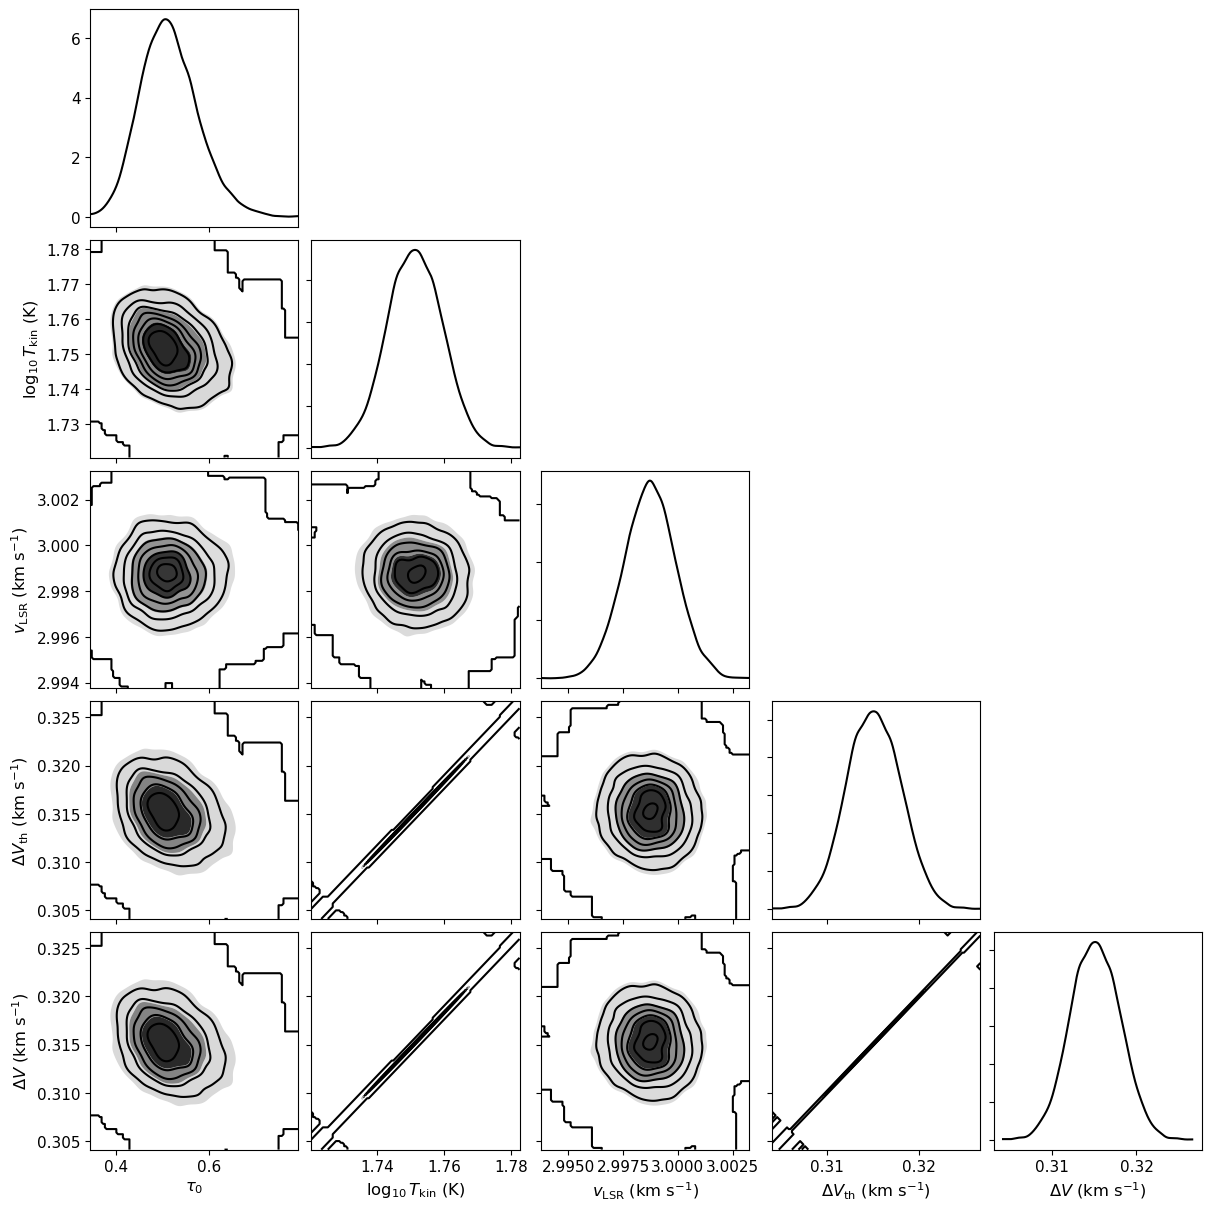

In [19]:
var_names = [param for param in model.cloud_deterministics if param not in ["Tex", "log10_anomaly"]]
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

In [20]:
var_names=model.cloud_deterministics + model.baseline_deterministics + model.hyper_deterministics
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -3952.131318437788


,mean,sd,hdi_16%,hdi_84%
tau_total[0],0.515,0.062,0.448,0.567
tau_total[1],2.072,0.289,1.763,2.325
tau_total[2],0.963,0.123,0.828,1.066
log10_Tkin[0],1.751,0.008,1.744,1.760
log10_Tkin[1],1.238,0.013,1.225,1.251
log10_Tkin[2],1.507,0.009,1.498,1.516
velocity[0],2.999,0.001,2.998,3.000
velocity[1],0.001,0.001,0.000,0.002
velocity[2],-3.001,0.001,-3.002,-3.000
fwhm_thermal[0],0.315,0.003,0.313,0.318


## Model Degeneracies

In the above example, the data contain sufficient information to break the degeneracy between excitation temperature and optical depth. This is not always true. If (1) the optical depths are small (difficult to constrain optical depth from hyperfine transition ratios), (2) the spectral resolution is poor (hard to measure line width), or (3) non-thermal broadening is important, then the degeneracy will be important. This is especially true when we consider hyperfine anomalies -- the excitation temperature of each transition is a free parameter, and thus there is no difference between, for example, an LTE model (Tkin = Tex) with large anomalies vs. a fixed Tkin model with Tkin > Tex and small anomalies. If Tkin cannot be constrained by the line width, then allowing hyperfine anomalies is equivalent to letting Tex be a free parameter. Tex can only be reliably derived in the optically-thin limit in this case.

Anyway, here we demonstrate this problem.

300


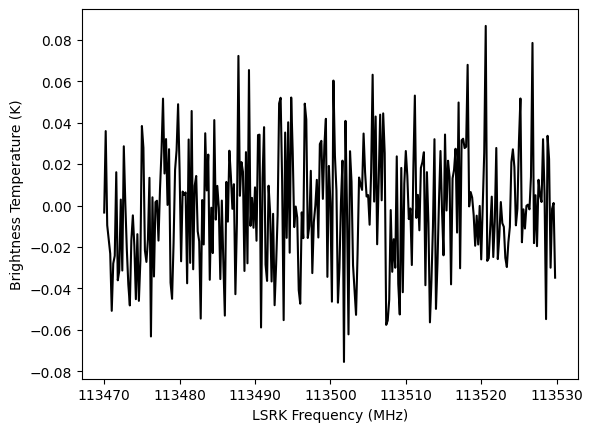

In [21]:
from bayes_spec import SpecData

# spectral axis definition
# freq_axis = np.arange(113470.0, 113530.0, 0.06) # MHz
freq_axis = np.arange(113470.0, 113530.0, 0.2) # MHz
print(len(freq_axis))

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

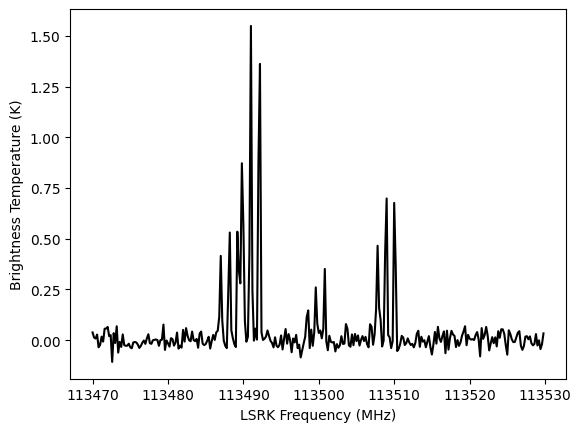

In [22]:
from bayes_cn_hfs import HFSAnomalyModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = HFSAnomalyModel(
    dummy_data,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total = 1.0, # width of total optical depth prior
    prior_log10_Tkin = [1.5, 0.2], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal FWHM prior (km/s)
    prior_log10_anomaly = 0.1, # width of hyperfine anomaly prior (dex)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # default baseline priors
    fix_tau_total = None, # do not assume tau_total
    fix_log10_Tkin = None, # do not assume Tkin
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

log10_anomaly = np.zeros((len(model.mol_data['freq']), n_clouds))
for i, freq in enumerate(model.mol_data['freq']):
    if freq == 113499.643:
        log10_anomaly[i] = -0.2
    elif freq == 113508.934:
        log10_anomaly[i] = 0.2

sim_brightness = model.model.observation.eval({
    "tau_total": [0.25, 0.5, 0.1],
    "log10_Tkin": [1.5, 1.25, 1.75],
    "velocity": [-3.0, 0.0, 3.0],
    "fwhm_nonthermal": [0.25, 0.5, 0.75],
    "fwhm_L": 0.0,
    "baseline_observation_norm": [0.0],
    "log10_anomaly": log10_anomaly,
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [23]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

In [24]:
# Initialize and define the model
model = HFSAnomalyModel(
    data,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total = 1.0, # width of total optical depth prior
    prior_log10_Tkin = [1.5, 0.2], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal FWHM prior (km/s)
    prior_log10_anomaly = 0.1, # width of hyperfine anomaly prior (dex)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # default baseline priors
    fix_tau_total = None, # do not assume tau_total
    fix_log10_Tkin = None, # do not assume Tkin
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

## MCMC

In [25]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5000
Interrupted at 4,999 [4%]: Average Loss = 2,612.4
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, tau_total_norm, log10_Tkin_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_anomaly_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 725 seconds.


Adding log-likelihood to trace


Output()

Runtime: 12.82 minutes


In [26]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [27]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_observation_norm[0],-0.258,0.011,-0.279,-0.239,0.000,0.000,8683.0,5941.0,1.0
log10_Tkin_norm[0],-0.510,0.999,-2.317,1.406,0.018,0.012,3230.0,2961.0,1.0
log10_Tkin_norm[1],-0.756,1.018,-2.638,1.139,0.016,0.011,4277.0,4996.0,1.0
log10_Tkin_norm[2],-0.759,0.983,-2.622,0.984,0.017,0.012,3289.0,3156.0,1.0
velocity_norm[0],-1.000,0.002,-1.003,-0.997,0.000,0.000,9269.0,6127.0,1.0
velocity_norm[1],1.001,0.005,0.993,1.010,0.000,0.000,9074.0,5937.0,1.0
velocity_norm[2],0.002,0.003,-0.003,0.008,0.000,0.000,8867.0,6230.0,1.0
"log10_anomaly_norm[113123.3687, 0]",0.012,0.996,-1.965,1.763,0.010,0.012,9823.0,6209.0,1.0
"log10_anomaly_norm[113123.3687, 1]",-0.021,1.020,-1.959,1.905,0.010,0.012,10217.0,5692.0,1.0
"log10_anomaly_norm[113123.3687, 2]",0.009,1.009,-1.801,1.983,0.011,0.012,8579.0,6192.0,1.0


Sampling: [observation]


Output()

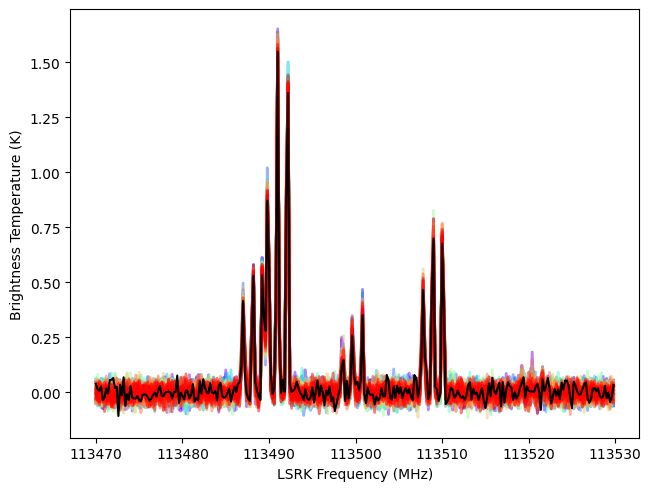

In [28]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

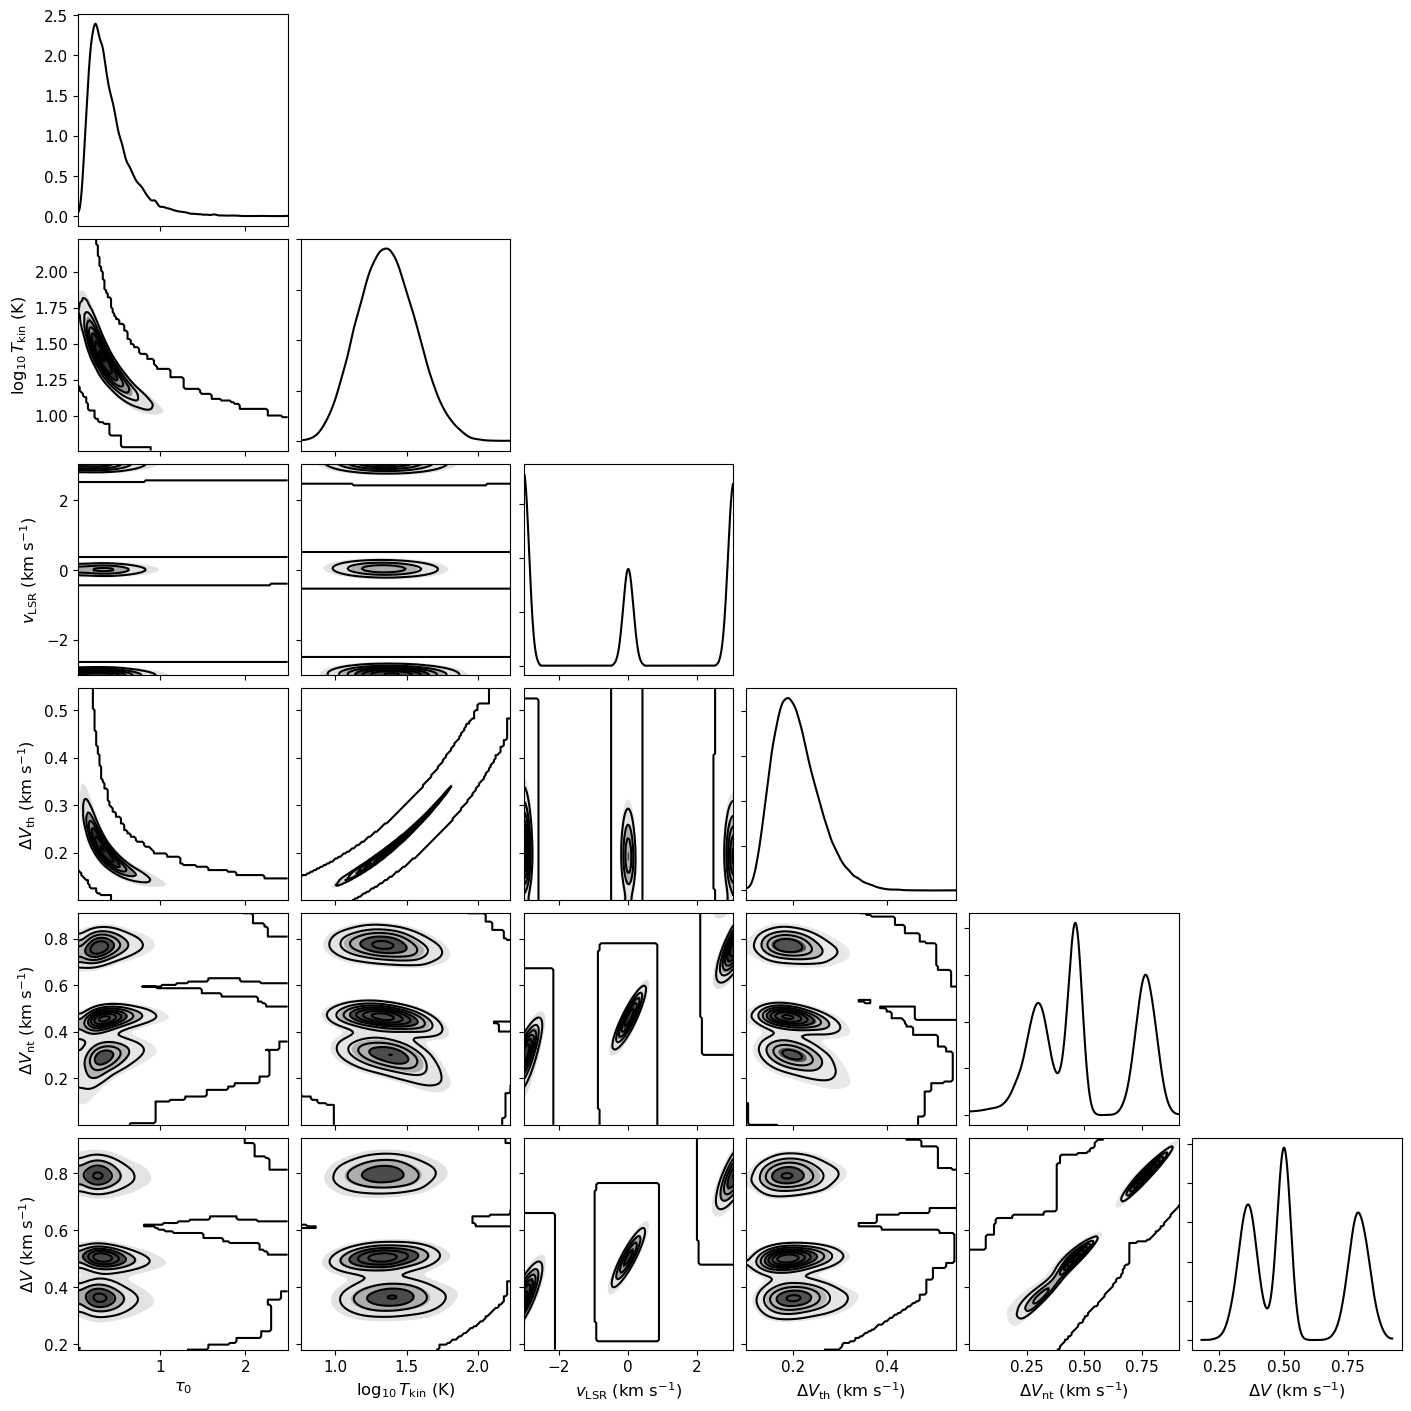

In [29]:
from bayes_spec.plots import plot_pair

var_names = [param for param in model.cloud_deterministics if param not in ["Tex", "log10_anomaly"]]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice the strong degeneracy between optical depth and kinetic temperature. The kinetic temperature posterior is basically just the prior, so we have a degenerate model that is not able to constrain the kinetic temperature.

## Overcoming Model Degeneracies

To overcome the model degeneracy problem, we must either assume a kinetic temperature or assume a total optical depth. Since this model also includes hyperfine anomalies, we generally lose the ability to estimate both the excitation temperature and the optical depth, especially in the optically thick limit. Changes in line ratios due to optical depth effects are just as easily modeled as hyperfine anomalies. We could set a narrow prior on the anomaly to prefer LTE solutions, but there will always be a degeneracy. The `HFSAnomalyModel` is simply poorly constrained.

Here we fix both the total optical depth as well as the kinetic temperature.

In [30]:
# Initialize and define the model
model = HFSAnomalyModel(
    data,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal FWHM prior (km/s)
    prior_log10_anomaly = 0.1, # width of hyperfine anomaly prior (dex)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # default baseline priors
    fix_tau_total = 0.25, # assume tau_total
    fix_log10_Tkin = 1.5, # assume log10_Tkin
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

In [31]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5300
Interrupted at 5,299 [5%]: Average Loss = 1,615.2
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_anomaly_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 60 seconds.


Adding log-likelihood to trace


Output()

There were 58 divergences in converged chains.
Runtime: 1.75 minutes


In [32]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [33]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])

solutions: [0]


/var/lib/condor/execute/slot1/dir_3869349/.local/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_observation_norm[0],-0.260,0.011,-0.282,-0.240,0.000,0.000,7211.0,4702.0,1.0
velocity_norm[0],0.002,0.003,-0.003,0.008,0.000,0.000,5966.0,4287.0,1.0
velocity_norm[1],-1.000,0.002,-1.003,-0.997,0.000,0.000,6947.0,4506.0,1.0
velocity_norm[2],1.001,0.005,0.992,1.010,0.000,0.000,4332.0,2469.0,1.0
"log10_anomaly_norm[113123.3687, 0]",0.010,0.996,-1.784,1.966,0.011,0.013,8179.0,4871.0,1.0
"log10_anomaly_norm[113123.3687, 1]",-0.006,1.006,-1.894,1.890,0.011,0.014,8592.0,5058.0,1.0
"log10_anomaly_norm[113123.3687, 2]",0.008,0.992,-1.896,1.843,0.010,0.013,9399.0,5094.0,1.0
"log10_anomaly_norm[113144.19, 0]",-0.002,1.027,-1.955,1.936,0.012,0.015,7645.0,3831.0,1.0
"log10_anomaly_norm[113144.19, 1]",0.000,1.022,-1.924,1.932,0.012,0.014,7199.0,4794.0,1.0
"log10_anomaly_norm[113144.19, 2]",-0.007,1.007,-1.900,1.920,0.011,0.014,8841.0,4329.0,1.0


Sampling: [observation]


Output()

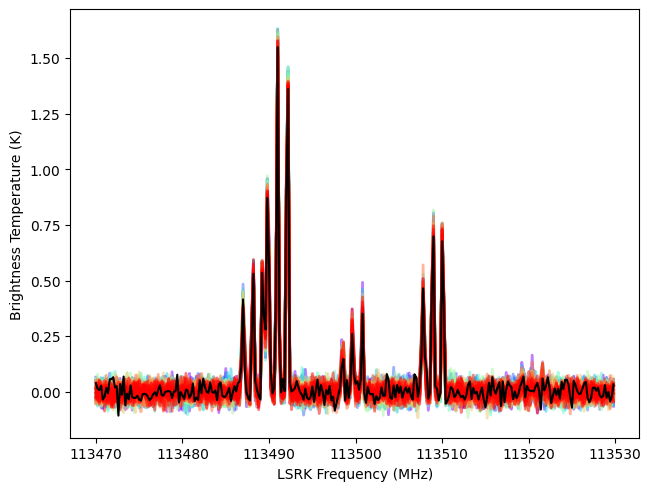

In [34]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

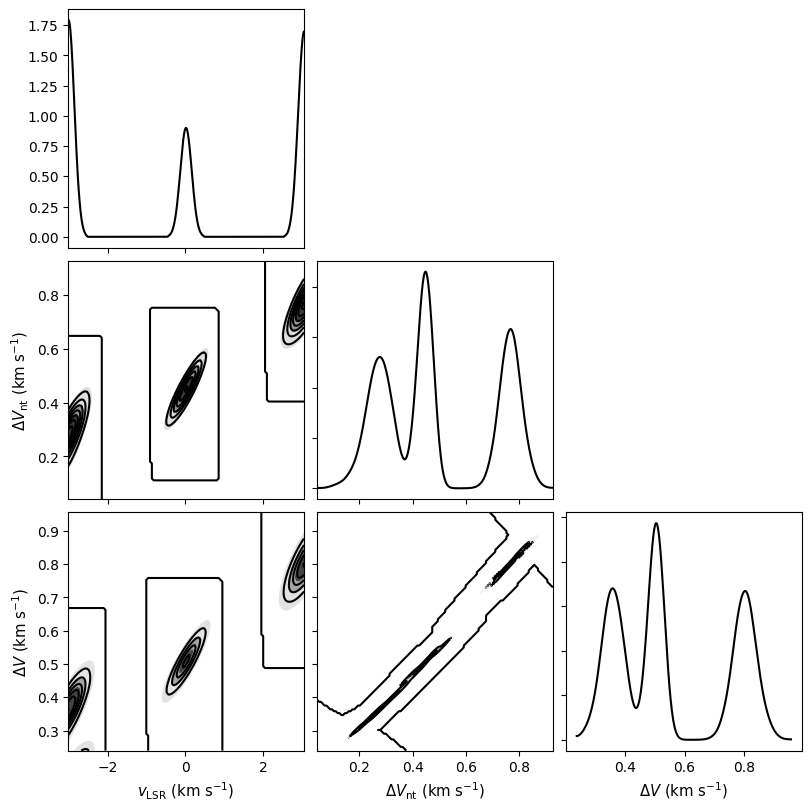

In [35]:
from bayes_spec.plots import plot_pair

var_names = [param for param in model.cloud_deterministics if param not in ["fwhm_thermal", "Tex", "log10_anomaly"]]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

Et voila, no more degeneracy, but also no constraints on the total optical depth or the relative optical depths between cloud components. At least you get the hyperfine transition relative intensities, though!